In [0]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}


E: Package 'python-software-properties' has no installation candidate
··········


<a href="https://colab.research.google.com/github/pedrostardust/ConflictSolver_RL/blob/master/DQN_Conflicter_DATA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#@title Default title text
from google.colab import drive
drive.mount('/content/drive')

% cd "/content/drive/My Drive/Colab Notebooks"
!pwd
!ls

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive
/content/drive/My Drive/Colab Notebooks
/content/drive/My Drive/Colab Notebooks
 calendar.xlsx		        ngrok
'Check Scheduling Input.xlsx'   ngrok-stable-linux-amd64.zip
 conflicter_solver.ipynb        ngrok-stable-linux-amd64.zip.1
 log			        results.xlsx


In [6]:
!pip install xlsxwriter
!pip install tensorflow==1.14
!pip install simplejson

     |████████████████████████████████| 81kB 3.7MB/s 
  Created wheel for simplejson: filename=simplejson-3.16.0-cp36-cp36m-linux_x86_64.whl size=114021 sha256=bb93e2b329c5115ba722ba70e83876190708cc6621b80fa679ab04442b84ca57
  Stored in directory: /root/.cache/pip/wheels/5d/1a/1e/0350bb3df3e74215cd91325344cc86c2c691f5306eb4d22c77
Successfully built simplejson


In [2]:
!rm -r -f /log/

!mkdir log

LOG_DIR = './log'
get_ipython().system_raw(
    'tensorboard --logdir="/log" --host 0.0.0.0 --port 6006 &'
    .format(LOG_DIR)
)

!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip ngrok-stable-linux-amd64.zip

get_ipython().system_raw('./ngrok http 6006 &')



! curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])" 
    
   

mkdir: cannot create directory ‘log’: File exists
--2019-10-15 10:33:10--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 52.206.196.238, 35.170.171.200, 54.164.252.120, ...
Connecting to bin.equinox.io (bin.equinox.io)|52.206.196.238|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13773305 (13M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip.2’

ngrok-stable-linux- 100%[===================>]  13.13M  30.9MB/s    in 0.4s    

2019-10-15 10:33:11 (30.9 MB/s) - ‘ngrok-stable-linux-amd64.zip.2’ saved [13773305/13773305]

Archive:  ngrok-stable-linux-amd64.zip
replace ngrok? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: ngrok                   
http://bd092bae.ngrok.io


In [0]:
import pandas as pd
import xlsxwriter
import simplejson as json
from datetime import *


def date_to_day(d):
    day = (d - date.today()).days
    return day


def day_to_date(day):
    return date.today() + timedelta(day)


def xlxs_to_matrix(filename):
    df = pd.read_excel(filename)
    matrix = df.as_matrix()
    matrix = np.asarray(matrix)
    for l in matrix:
        l[0] -= 1
        l[2] -= 1

    return matrix


def file_to_info(filename):
    names = ["D_INITIAL", "C_INITIAL", "A_INITIAL", "DFH", "DFC", "C_ELAPSED_TIME",
             "ADDITIONAL", "C_NOT_ALLOWED", "MORE_C_SLOTS", "PUBLIC_HOLIDAYS",
             "A_NOT_ALLOWED", "MORE_A_SLOTS"]
    info = []

    for i in range(12):
        df = pd.read_excel(filename, sheet_name=names[i])
        matrix = np.asarray(df.to_numpy())
        info.append(matrix)

    return info


def render_calendar_excel(env, name):
    # print(env.reward_calendar())
    workbook = xlsxwriter.Workbook(name)
    ws = workbook.add_worksheet()
    info = workbook.add_worksheet()

    c_format = workbook.add_format()
    c_format.set_pattern(1)
    c_format.set_bg_color('green')

    a_format = workbook.add_format()
    a_format.set_pattern(1)
    a_format.set_bg_color('blue')

    tolerance_used_format = workbook.add_format()
    tolerance_used_format.set_pattern(1)
    tolerance_used_format.set_bg_color('red')

    row = 0
    column = 0
    for d in range(len(env.calendar)):
        day = env.calendar[d]

        ws.write(row, column, str(day.date)) # write date
        # ws.write(row, column, date_to_day(day.date))
        row += 1

        sorted_list = sorted(day.c_checks, key=lambda x: x.number)

        for c in range(len(sorted_list)):  # paint c_checks
            ws.write(row + c, column, sorted_list[c].number, c_format)

        row += 3
        for c in range(len(day.a_checks)):  # paint a_checks
            ws.write(row, column, day.a_checks[c].number, a_format)

        if d % 50 != 0 or d == 0:  # don't change line
            column += 1
            row -= 4
        else:  # change line
            row += 1
            column = 0

    row = 0
    column = 0
    for t in env.task_list:
        info.write(row, column, t.number)
        if t.starting_day != -1:
            diff = (t.due_date - t.starting_day).days
            if diff < 0:
                info.write(row, column + 1, diff, tolerance_used_format)
            elif t.type == "c-check":
                info.write(row, column + 1, diff, c_format)
            else:
                info.write(row, column + 1, diff, a_format)
        else:
            info.write(row, column + 1, "Not Found")

        # info.write(row, column + 2, t.type)

        if t.number % 30 != 0 or t.number == 0:  # dont change line
            column += 2
        else:
            row += 1
            column = 0

    workbook.close()


def render_results_excel(agent, mean_rewards, max_reward, episode_conflicts, best_episode_conflicts, c_before,
                         c_after, a_before, a_after):
    workbook = xlsxwriter.Workbook('results.xlsx')
    worksheet = workbook.add_worksheet()
    # hyperparameters = workbook.add_worksheet()
    worksheet.write_row(0, 0, mean_rewards)
    hyper_strings = ["n.layers", "layer1", "layer2", "layer3", "activation", "initializer",
                     "output activation", "optimizer", "gamma", "buffer_size", "batch_size", "target_update",
                     "learning rate", "max episodes"]
    hyper_values = [n_layers, layer1nodes, layer2nodes, layer3nodes, activation_function,
                    "tf.contrib.layers.variance_scaling_initializer()",
                    "None", "adam", agent.gamma, agent.buffer_size, agent.batch_size, agent.target_update_freq,
                    agent.learning_rate, agent.max_episodes]
    worksheet.write_row(2, 0, hyper_strings)
    worksheet.write_row(3, 0, hyper_values)

    max_value = ["max value", max_reward]
    worksheet.write_row(5, 0, max_value)

    conflicts = ["Mean conflicts:", sum(episode_conflicts) / len(episode_conflicts),
                 "Number of conflicts in best episode:", best_episode_conflicts]
    worksheet.write_row(7, 0, conflicts)

    tasks_position = ["C tasks before:", c_before, "C tasks after:", c_after, "A tasks before:", a_before,
                      "A tasks after:", a_after]
    worksheet.write_row(8, 0, tasks_position)

    workbook.close()


def create_json(env):
    d = {}
    # go through all aircraft
    for i in range(env.c_initial.shape[0]):
        aircraft = env.c_initial[i][1]
        # find all tasks related with this aircraft
        task_list = []
        for task in env.task_list:
            if aircraft == task.tail_number:
                task_info = {"id": task.id, "number": task.number, "type": task.type, "priority": task.priority,
                             "due date": str(task.due_date), "length": task.length,
                             "starting day": str(task.starting_day), "end day": str(task.end_day),
                             "aircraft": task.tail_number, "fleet": task.fleet}
                task_list.append(task_info)
        d[aircraft] = task_list

    j = json.dumps(d, indent=4)
    with open('data.json', 'w') as f:
        f.write(j)


def build_input_json(tasks):
    d = {}
    for task in tasks:
        d[task.id] = {"due date": str(task.due_date), "tolerance": str(task.tolerance), "priority": str(task.priority)}
    j = json.dumps(d, indent=4)
    with open('input.json', 'w') as f:
        f.write(j)


def task_oriented_json(env):
    d = {}
    sorted_tasks = sorted(env.task_list, key=lambda x: date_to_day(x.due_date))
    for task in sorted_tasks:
        task_info = {"number": task.number, "type": task.type, "due date": str(task.due_date), "priority": task.priority,
                     "length": task.length, "starting day": str(task.starting_day), "end day": str(task.end_day),
                     "aircraft": task.tail_number, "fleet": task.fleet}
        d[task.id] = task_info

    j = json.dumps(d, indent=4)
    with open('tasks.json', 'w') as f:
        f.write(j)


def maintenance_plan_json(env):
    d = {}
    calendar = env.calendar
    for day in calendar:
        # c_check_ids = [task.id for task in day.c_checks]
        # a_check_ids = [task.id for task in day.a_checks]
        c_task = {}
        a_task = {}
        for task in day.c_checks:
            if day.date == task.end_day:
                c_task[task.id] = {"state": "1"}
            else:
                c_task[task.id] = {"state": "0"}
        for task in day.a_checks:
            if day.date == task.end_day:
                a_task[task.id] = {"state": "1"}
            else:
                a_task[task.id] = {"state": "0"}
        day_info = {"c-checks": c_task, "a-checks": a_task}
        d[str(day.date)] = day_info

    j = json.dumps(d, indent=4)
    with open('plan.json', 'w') as f:
        f.write(j)


# finds if the tasks with the same due date were scheduled properly, i.e, if the tasks with
# higher priority were scheduled first
def evaluate_priorities():
    with open("tasks.json") as json_file:
        tasks = json.load(json_file)
        current_due_date = 0
        wrong_tasks = []
        current_tasks = []
        for task_id in tasks:
            temp_due_date = date_to_day(datetime.strptime(tasks[task_id].get("due date"), '%Y-%m-%d').date())
            if current_due_date == temp_due_date:
                current_tasks.append([task_id, tasks[task_id].get("priority"), tasks[task_id].get("starting day")])
            else:
                if len(current_tasks) > 1:
                    for i in range(len(current_tasks)):
                        for j in range(i, len(current_tasks)):
                            if current_tasks[i][1] < current_tasks[j][1] and current_tasks[i][2] < current_tasks[j][2]:
                                if current_tasks[i] not in wrong_tasks:
                                    wrong_tasks.append(current_tasks[i])
                                if current_tasks[j] not in wrong_tasks:
                                    wrong_tasks.append(current_tasks[j])
                current_due_date = temp_due_date
                current_tasks = []

    print(wrong_tasks)


# evaluate_priorities()


In [0]:
import numpy as np


class Day:
    def __init__(self, date):
        self.date = date

        self.c_checks = []
        self.a_checks = []


class Hangar:
    def __init__(self, n_days, n_tasks):
        self.n_tasks = n_tasks
        self.n_days = n_days
        self.calendar = np.zeros((n_tasks, n_days))

    def available_day(self, task, due_date, length):
        for i in range(due_date, length-2, -1):
            if all(v == 0 for v in self.calendar[task][i-length+1:i+1]):
                return i
        return -1

    def available_day_after(self, due_date, length):
        d = -1
        for i in range(due_date-length+1, self.n_days):
            possible = True
            for t in range(self.n_tasks):
                if all(v == 0 for v in self.calendar[t][i:i+length]):
                    d = i
                else:
                    possible = False

            if possible:
                return d + length - 1
        return -1

    def schedule_maintenance(self, task, day, length):
        self.calendar[task][day-length+1:day+1] = 1


class Task:
    def __init__(self, id, type, length, interval, tolerance, prev_check, number, fleet, tail_number, priority):
        self.id = id
        self.type = type
        self.length = length
        self.interval = interval
        self.tolerance = tolerance
        self.number = number
        self.prev_check = prev_check

        self.fleet = fleet
        self.tail_number = tail_number

        self.due_date = -1
        self.starting_day = -1
        self.end_day = -1
        self.hangar = -1

        self.priority = priority

        self.up = False


class Aircraft:
    def __init__(self, fleet, tail_number):
        self.fleet = fleet
        self.tail_number = tail_number
        self.tasks = []


class Conflict:
    def __init__(self, tasks):
        self.tasks = tasks


In [0]:
# Earliest Due Date: EDD (changed to Earliest Scheduled Day)
# Tardiest Due Date: TDD (changed to Tardiest Scheduled Day)
# Shortest Length First: SLF
# Longest Length First: LLF


list_rules = ["EDD", "FCFS", "MUF"]


def n_rules():
    return len(list_rules)


def edd(tasks):
    bigger = 9999
    m = None

    for t in tasks:
        if date_to_day(t.due_date) < bigger:
            bigger = date_to_day(t.due_date)
            m = t
    return m


def tdd(tasks):
    bigger = -9999
    m = None
    for t in tasks:
        if date_to_day(t.due_date) > bigger:
            bigger = date_to_day(t.due_date)
            m = t
    return m


def slf(tasks):
    bigger = 9999
    m = None
    for t in tasks:
        if t.length < bigger:
            bigger = t.length
            m = t
    return m


def llf(tasks):
    bigger = -9999
    m = None
    for t in tasks:
        if t.length > bigger:
            bigger = t.length
            m = t
    return m


In [10]:
import gym
import copy
from collections import deque
from gym import spaces
import random

MAX_PRIORITY = 1


class SchedulingEnv(gym.Env):

    def __init__(self):
        self.info = file_to_info("Check Scheduling Input.xlsx")
        self.c_initial = self.info[1]
        self.a_initial = self.info[2]
        self.additional = self.info[6]
        self.c_not_allowed = self.info[7]
        self.a_not_allowed = self.info[10]
        self.c_elapsed_time = self.info[5]
        self.n_days = 2190
        self.n_tasks = len(self.c_initial) + len(self.a_initial)
        self.a_slots = 1
        self.c_slots = 3
        self.a_length = 1
        self.c_length = 21
        self.c_interval = 3

        self.c_tasks_before = 0
        self.c_tasks_after = 0
        self.a_tasks_before = 0
        self.a_tasks_after = 0
        self.conf_number = 0
        self.c_check_conf_number = 0
        self.a_check_conf_number = 0

        self.last_c_days = [task[4] for task in self.c_initial]
        self.last_elapsed_index = np.zeros(len(self.c_initial))
        self.last_a_days = [task[4] for task in self.a_initial]
        # Calendar
        today_date = date.today()
        self.calendar = []
        for i in range(self.n_days):
            self.calendar.append(Day(today_date + timedelta(days=i)))

        self.aircraft = []
        self.task_list = []
        self.conflicts = deque()
        self.last_scheduled = 0
        self.done = False

        self.observation_space = spaces.Box(low=0, high=1, shape=(15, 100))     # Partial Calendar
        self.state = None

        self.action_space = spaces.Discrete(4)  # Number of dispatching rules

        self.more_tasks = False

        self.init_aircraft()
        self.create_tasks()
        build_input_json(self.task_list)

        self.backup = copy.deepcopy(self.task_list)

    def reward_calendar(self):
        reward = 0

        for task in self.task_list:
            starting_day = date_to_day(task.starting_day)
            due_day = date_to_day(task.due_date)
            if starting_day == -1:
                reward -= 100
            elif starting_day <= due_day:
                reward -= (due_day - starting_day) * (MAX_PRIORITY - task.priority + 1)

                if task.type == "c-check":
                    self.c_tasks_before += 1
                else:
                    self.a_tasks_before += 1

            else:
                reward -= 10 * (starting_day - due_day) * (MAX_PRIORITY - task.priority + 1)

                if task.type == "c-check":
                    self.c_tasks_after += 1
                else:
                    self.a_tasks_after += 1

        return reward

    def reset(self):
        self.c_tasks_before = 0
        self.c_tasks_after = 0

        self.a_tasks_before = 0
        self.a_tasks_after = 0

        self.conf_number = 0
        self.c_check_conf_number = 0
        self.a_check_conf_number = 0
        self.last_scheduled = 0
        self.done = False
        self.conflicts = deque()
        self.more_tasks = False

        self.c_initial = self.info[1]
        self.a_initial = self.info[2]
        self.additional = self.info[6]
        self.c_not_allowed = self.info[7]
        self.a_not_allowed = self.info[10]
        self.last_elapsed_index = np.zeros(len(self.c_initial))
        self.task_list = copy.deepcopy(self.backup)

        self.n_tasks = len(self.c_initial) + len(self.a_initial)
        self.a_slots = 1
        self.c_slots = 3
        self.a_length = 1
        self.c_length = 21
        self.c_interval = 3

        self.last_c_days = [task[4] for task in self.c_initial]
        self.last_a_days = [task[4] for task in self.a_initial]

        # Calendar
        today_date = date.today()
        self.calendar = []
        for i in range(self.n_days):
            self.calendar.append(Day(today_date + timedelta(days=i)))

        if not self.conflicts:  # if there are no conflicts #(maybe can be removed)#
            # schedules every task (starting in task 0) to its due date until it finds one conflict
            while self.last_scheduled < len(self.task_list) and not self.conflicts:
                if date_to_day(self.task_list[self.last_scheduled].due_date) < self.n_days:
                    self.schedule_maintenance(self.task_list[self.last_scheduled])
                self.last_scheduled += 1

        if not self.conflicts:
            self.done = True
            self.build_state()
        else:
            self.build_state()
        return self.state

    def step(self, action):
        self.conf_number += 1
        # TODO: Simulador devolve a reward imediatamente e o agente verifica
        # se ha um novo conflito senao nao faz nada ate haver
        assert(action < 4), "Invalid action"
        conflict = self.conflicts[-1]

        if conflict.tasks[0].type == "c-check":
            self.c_check_conf_number += 1
        else:
            self.a_check_conf_number += 1

        if action == 0:
            move = edd(conflict.tasks)
        elif action == 1:
            move = tdd(conflict.tasks)
        elif action == 2:
            move = llf(conflict.tasks)
        else:
            move = slf(conflict.tasks)

        self.move_maintenance(move)

        if not self.conflicts:  # if there are no conflicts
            # schedules every task (starting in task 0) to its due date until it finds one conflict
            while self.last_scheduled < len(self.task_list) and not self.conflicts:
                if date_to_day(self.task_list[self.last_scheduled].due_date) < self.n_days:
                    self.schedule_maintenance(self.task_list[self.last_scheduled])
                self.last_scheduled += 1

        if not self.conflicts:
            self.done = True
            self.build_state()
        else:
            self.build_state()

        reward = self.calculate_rewards(conflict.tasks)

        return self.state, reward, self.done, {}

    def schedule_maintenance(self, task, move=False):
        self.more_tasks = True

        if move:
            diff = date_to_day(task.starting_day)
        else:
            diff = date_to_day(task.due_date)
            task.starting_day = task.due_date
            task.end_day = task.starting_day + timedelta(task.length-1)

        t_type = task.type

        if t_type == "a-check":
            self.calendar[diff].a_checks.append(task)

        elif t_type == "c-check":  # Schedule c-check in the several days
            for i in range(date_to_day(task.starting_day), date_to_day(task.end_day) + 1):
                self.calendar[i].c_checks.append(task)

        # Checking conflicts
        self.check_conflicts(task)

        # Change due date following task
        for i in range(task.number + 1, len(self.task_list), 1):
            # use the id to verify the next tasks
            if self.task_list[i].id[:-1] == task.id[:-1]:
                self.task_list[i].due_date = task.starting_day + timedelta(days=task.interval)
                break

    def move_maintenance(self, task):
        i = 0
        while i < len(self.conflicts):  # Erase other conflicts with this task
            for k in range(len(self.conflicts[i].tasks)):
                t = self.conflicts[i].tasks[k]
                if t.id == task.id:
                    if len(self.conflicts[i].tasks) <= 4:
                        del self.conflicts[i]
                        i -= 1
                        break
                    else:
                        del self.conflicts[i].tasks[k]
                        break
            i += 1

        # Find new day
        found = True
        previous_start_day = date_to_day(task.starting_day)
        previous_end_day = date_to_day(task.end_day)

        if task.type == "a-check":
            new_day = task.starting_day - timedelta(1)

            if date_to_day(new_day) >= 0 and not task.up:
                task.starting_day = new_day
                task.end_day = task.starting_day + timedelta(task.length - 1)

            else:
                # enters here only if the task could not be scheduled before its due date
                task.up = True
                new_day = task.starting_day + timedelta(1)
                if new_day < task.due_date + timedelta(task.tolerance) and new_day < day_to_date(self.n_days):
                    task.starting_day = new_day
                    task.end_day = task.starting_day + timedelta(task.length - 1)
                else:
                    print("not found:", task.number, date_to_day(task.due_date))
                    found = False

        elif task.type == "c-check":
            new_day = self.find_closest_c_day(task)
            if date_to_day(new_day) >= 0 and not task.up:
                task.starting_day = new_day
                task.end_day = task.starting_day + timedelta(task.length - 1)
            else:
                # enters here only if the task could not be scheduled before its due date
                task.up = True
                new_day = self.search_c_tolerance(task)
                if new_day < task.due_date + timedelta(task.tolerance) and new_day < day_to_date(self.n_days):
                    task.starting_day = new_day
                    task.end_day = task.starting_day + timedelta(task.length - 1)
                else:
                    print("not found:", task.number, date_to_day(task.due_date))
                    found = False

        if task.type == "a-check":  # Erase task from calendar
            for d in range(previous_start_day, previous_end_day + 1):
                i = 0
                while i < (len(self.calendar[d].a_checks)):
                    # delete the same task in the days after
                    t = self.calendar[d].a_checks[i]
                    if t.id == task.id:
                        del self.calendar[d].a_checks[i]
                        i -= 1
                    i += 1

        elif task.type == "c-check":  # Erase task from calendar
            for d in range(previous_start_day, previous_end_day + 1):
                i = 0
                while i < (len(self.calendar[d].c_checks)):
                    # delete the same task in the days after
                    t = self.calendar[d].c_checks[i]
                    if t.id == task.id:
                        del self.calendar[d].c_checks[i]
                        i -= 1
                    i += 1

        if found:
            self.schedule_maintenance(task, move=True)
        else:
            task.starting_day = day_to_date(-1)
            task.end_day = day_to_date(-1)

    def check_conflicts(self, task):
        start_day = date_to_day(task.starting_day)
        end_day = date_to_day(task.end_day)
        for d in range(start_day, end_day + 1):
            new_conf = Conflict([task])
            if task.type == "c-check":
                checking_day = self.calendar[d]
                if len(checking_day.c_checks) > 3:
                    for t in checking_day.c_checks:
                        # if the task is not in the conflict already, add it
                        if self.check_containts(t, new_conf.tasks) == -1:
                            new_conf.tasks.append(t)
            if len(new_conf.tasks) > 3:
                self.conflicts.append(new_conf)

            elif task.type == "a-check":
                if len(self.calendar[start_day].a_checks) > 1:
                    new_conf = Conflict(self.calendar[start_day].a_checks)
                    self.conflicts.append(new_conf)

    # finds the closest available slot to move a c-check which is right before the last starting_day of
    # all the tasks in the conflict
    def find_closest_c_day(self, task):
        bigger_start_day = -99999
        for d in range(date_to_day(task.starting_day), date_to_day(task.end_day) + 1):
            conflicted = self.calendar[d].c_checks
            for c in conflicted:
                if date_to_day(c.starting_day) > bigger_start_day:
                    bigger_start_day = date_to_day(c.starting_day)

        return day_to_date(bigger_start_day - task.length)

    # finds the first available slot in the tolerance of a c-check
    def find_c_tolerance(self, task):
        due_date = date_to_day(task.due_date)
        for d in range(due_date, due_date + task.tolerance):
            if len(self.calendar[d].c_checks) < self.c_slots:
                return day_to_date(d)
        return -1

    def search_c_tolerance(self, task):
        lesser = -99999
        for d in range(date_to_day(task.starting_day), date_to_day(task.end_day) + 1):
            conflicted = self.calendar[d].c_checks
            for c in conflicted:
                if date_to_day(c.starting_day) > lesser:
                    lesser = date_to_day(c.starting_day)

        if lesser == -99999:
            lesser = date_to_day(task.starting_day)

        if (lesser + task.length) < (date_to_day(task.due_date) + task.tolerance) and (
                lesser + task.length) < self.n_days:
            return day_to_date(lesser + task.length)

        return day_to_date(lesser + task.length)

    def find_c_day(self, task):
        lesser = 99999
        for d in range(date_to_day(task.starting_day), date_to_day(task.end_day) + 1):
            conflicted = self.calendar[d].c_checks
            for c in conflicted:
                if date_to_day(c.starting_day) < lesser:
                    lesser = date_to_day(c.starting_day)

        return day_to_date(lesser - 1)

    def simulate_move(self, task, task_list):
        new_day = None
        # Find new day
        if task.type == "a-check":
            new_day = task.starting_day - timedelta(1)

            if date_to_day(new_day) >= self.a_length and not task.up:
                new_day = task.starting_day - timedelta(1)

            else:
                new_day = task.starting_day + timedelta(1)
                if new_day < task.due_date + timedelta(task.tolerance) and new_day < day_to_date(self.n_days):
                    new_day = task.starting_day + timedelta(1)
                else:
                    new_day = date.today() - timedelta(50)

        elif task.type == "c-check":
            new_day = self.find_c_day(task)

            if date_to_day(new_day) >= task.length and not task.up:
                new_day = self.find_c_day(task)

            else:
                new_day = self.search_c_tolerance(task)
                if new_day < task.due_date + timedelta(task.tolerance) and new_day < day_to_date(self.n_days):
                    new_day = self.search_c_tolerance(task)
                else:
                    new_day = date.today() - timedelta(50)

        reward = 0
        for t in task_list:
            if t.id != task.id:
                day = date_to_day(t.starting_day)
            else:
                day = date_to_day(new_day)

            due_date = date_to_day(t.due_date)

            if day <= due_date:
                reward -= due_date - day
            else:
                reward -= 5 * (day - due_date)

        return reward

    def init_aircraft(self):
        self.aircraft = []
        for a in range(len(self.c_initial)):
            self.aircraft.append(Aircraft(self.c_initial[a][0], self.c_initial[a][1]))

    def create_tasks(self):
        self.task_list = []
        task_number = 0
        a_checks = 0
        c_checks = 0

        # C-checks
        # iterates over each aircraft
        for index in range(len(self.c_initial)):
            first = True
            task_info = self.c_initial[index]
            # iterates over the length values of 5 future c-checks for each aircraft
            for c_check_index in range(2, len(self.c_elapsed_time[0])):
                t_length = self.c_elapsed_time[index][c_check_index]
                # if length == -1 then the aircraft is phased out
                if t_length == -1:
                    break
                else:
                    # define random priority
                    task_priority = random.randint(1, MAX_PRIORITY)
                    new_task = Task(str(task_info[1]) + "c" + str(c_check_index-2), "c-check", t_length, task_info[7],
                                    task_info[10], task_info[4], task_number, task_info[0], task_info[1], task_priority)
                    if first:
                        new_task.prev_check = - new_task.prev_check
                        new_task.due_date = (date.today() + timedelta(new_task.interval + new_task.prev_check))
                        first = False
                    else:
                        # prev_check is the due date of the last task done on the aircraft
                        new_task.prev_check = date_to_day(self.aircraft[index].tasks[-1].due_date)
                        new_task.due_date = day_to_date(new_task.prev_check + new_task.interval)

                    # If maintenance already passed its due date (rare) (case when t = 47)
                    if date_to_day(new_task.due_date) < 0:
                        new_task.due_date = day_to_date(t_length)

                    # If due date is less than the number of days the task is valid
                    if date_to_day(new_task.due_date) < self.n_days:
                        self.task_list.append(new_task)         # add new task to the global task list
                        self.aircraft[index].tasks.append(new_task) # add new task to the respective aircraft task list
                        c_checks += 1
                        task_number += 1

        # A-checks
        for index in range(len(self.a_initial)):
            first = True
            task_info = self.a_initial[index]
            t_length = 1
            current_day = 0
            count = 0
            while current_day < self.n_days:
                task_priority = random.randint(1, MAX_PRIORITY)
                new_task = Task(str(task_info[1]) + "a" + str(count), "a-check", self.a_length, task_info[7],
                                task_info[10], task_info[4], task_number, task_info[0], task_info[1], task_priority)
                if first:
                    new_task.prev_check = - new_task.prev_check
                    new_task.due_date = (date.today() + timedelta(new_task.interval + new_task.prev_check))
                    first = False
                else:
                    # prev_check is the due date of the last task done on the aircraft
                    new_task.prev_check = date_to_day(self.aircraft[index].tasks[-1].due_date)
                    new_task.due_date = day_to_date(new_task.prev_check + new_task.interval)

                # If maintenance already passed its due date (rare)
                if date_to_day(new_task.due_date) < 0:
                    new_task.due_date = day_to_date(t_length)

                # If due date is less than the number of days
                if date_to_day(new_task.due_date) < self.n_days:
                    self.task_list.append(new_task)  # add new task to the global task list
                    self.aircraft[index].tasks.append(new_task)  # add new task to the respective aircraft task list
                    a_checks += 1
                    task_number += 1
                    count += 1

                current_day = date_to_day(new_task.due_date)
        print("A-checks: ", a_checks, "   C-checks: ", c_checks, "   tasks: ", len(self.task_list))

    # creates every task
    def create_tasks_v2(self):
        self.task_list = []
        task_number = 0
        count = 0
        a_checks = 0
        c_checks = 0

        index = 0

        while index < self.n_days:
            more_tasks = False

            for t in range(len(self.c_initial)):
                task = self.c_initial[t]

                # Choose length from file
                length_index = int(self.last_elapsed_index[t]) + 2

                # len(self.c_elapsed_time[0]) is always 7
                if length_index >= len(self.c_elapsed_time[0]):
                    length = 20
                else:
                    length = int(self.c_elapsed_time[t][int(self.last_elapsed_index[t]) + 2])

                    if length != -1:
                        self.last_elapsed_index[t] += 1
                    else:
                        length = 10

                length += 5

                # Create task
                task_priority = random.randint(1, MAX_PRIORITY)
                new_task = Task(str(task[1]) + "c" + str(index), "c-check", length, task[7], task[10], task[4],
                                task_number, task[0], task[1], task_priority)

                # Due date according to the last scheduling equal task
                if index == 0:  # If its the first task use todays date
                    new_task.due_date = (date.today() + timedelta(new_task.interval - self.last_c_days[t]))
                    new_task.starting_day = new_task.due_date
                    new_task.end_day = new_task.starting_day + timedelta(new_task.length - 1)
                else:
                    new_task.due_date = day_to_date(self.last_c_days[t] + new_task.interval)
                    new_task.starting_day = new_task.due_date
                    new_task.end_day = new_task.starting_day + timedelta(new_task.length - 1)

                # If maintenance already passed its due date its gona be less than zero (rare) (case when t = 47)
                if date_to_day(new_task.due_date) < 0:
                    new_task.due_date = day_to_date(length)
                    new_task.starting_day = new_task.due_date
                    new_task.end_day = new_task.starting_day + timedelta(new_task.length - 1)

                # If due date is less than the number of days
                if date_to_day(new_task.due_date) < self.n_days and length != -1:
                    self.task_list.append(new_task)
                    c_checks += 1
                    more_tasks = True
                    task_number += 1
                    count += 1
                    self.last_c_days[t] = date_to_day(new_task.due_date)

            for t in range(len(self.a_initial)):
                task = self.a_initial[t]
                task_priority = random.randint(1, MAX_PRIORITY)
                new_task = Task(str(task[1]) + "a" + str(index), "a-check", self.a_length, task[7], task[10], task[4],
                                task_number, task[0], task[1], task_priority)

                if index == 0:
                    new_task.due_date = (date.today() + timedelta(new_task.interval - self.last_a_days[t]))
                    new_task.starting_day = new_task.due_date
                    new_task.end_day = new_task.starting_day + timedelta(new_task.length - 1)

                else:
                    new_task.due_date = day_to_date(self.last_a_days[t] + new_task.interval)
                    new_task.starting_day = new_task.due_date
                    new_task.end_day = new_task.starting_day + timedelta(new_task.length - 1)

                if date_to_day(new_task.due_date) < 0:
                    new_task.due_date = day_to_date(self.a_length)
                    new_task.starting_day = new_task.due_date
                    new_task.end_day = new_task.starting_day + timedelta(new_task.length - 1)

                if date_to_day(new_task.due_date) < self.n_days:
                    self.task_list.append(new_task)
                    a_checks += 1
                    more_tasks = True
                    task_number += 1
                    self.last_a_days[t] = date_to_day(new_task.due_date)

                    new_task.starting_day = new_task.due_date
                    new_task.end_day = new_task.starting_day + timedelta(new_task.length - 1)

            if not more_tasks:
                break

            index += 1

        print("a-checks: ", a_checks, "   c-checks: ", c_checks, "   tasks: ", len(self.task_list))

    def build_state(self):
        self.state = np.zeros((15, 100))
        if not self.conflicts:
            return
        conf = self.conflicts[-1]
        conf_tasks = conf.tasks

        # Save bigger and smaller day
        smaller = conf_tasks[0]
        bigger = conf_tasks[0]
        for t in conf_tasks:
            if t.starting_day < smaller.starting_day:
                smaller = t
            if t.starting_day > bigger.starting_day:
                bigger = t

        # Select a number of days before and after the conflict
        left_bound = date_to_day(smaller.starting_day) - self.c_length
        right_bound = date_to_day(bigger.starting_day) + self.c_length

        empty_spaces = 100 - (right_bound - left_bound)

        left_bound -= int(empty_spaces / 2)
        right_bound += int(empty_spaces / 2)

        days = []
        for t in conf_tasks:
            days.append(date_to_day(t.starting_day))

        if left_bound < 0:
            right_bound += 0 - left_bound
            left_bound = 0
        if right_bound > self.n_days:
            left_bound -= right_bound - self.n_days
            right_bound = self.n_days

        # Build State
        diff = 0
        for d in range(left_bound, right_bound):
            day = self.calendar[d]

            if conf_tasks[0].type == "c-check":
                checks = sorted(day.c_checks, key=lambda x: x.number)
                for t in range(len(checks)):
                    task = checks[t]
                    index = self.check_containts(task, conf_tasks)
                    if index != -1:
                        self.state[index][diff] = 2
            elif conf_tasks[0].type == "a-check":
                checks = sorted(day.a_checks, key=lambda x: x.number)
                for t in range(len(checks)):
                    task = checks[t]
                    index = self.check_containts(task, conf_tasks)
                    if index != -1:
                        self.state[index][diff] = 2
            diff += 1

        diff = 0
        array_index = len(conf_tasks)
        # Append tasks not in conflict
        for d in range(left_bound, right_bound):
            day = self.calendar[d]
            if conf_tasks[0].type == "c-check":
                for t in day.c_checks:
                    if self.check_containts(t, conf_tasks) == -1:
                        self.state[array_index][diff] += 1

            elif conf_tasks[0].type == "a-check":
                for t in day.a_checks:
                    if self.check_containts(t, conf_tasks) == -1:
                        self.state[array_index][diff] += 1
            diff += 1
        """
        array_index = len(conf_tasks)
        for i in range(len(not_conflicts)):
            t = not_conflicts[i]

            t_index = date_to_day(t.starting_day) - left_bound

            for k in range(t_index, t_index + t.length):
                if k < 100 and k > 0:
                    self.state[array_index][k] += 1
        """
        #np.set_printoptions(threshold=sys.maxsize)
        #print(self.state)

    def check_containts(self, task, array):
        for i in range(len(array)):
            t = array[i]
            if t.id == task.id:
                return i
        return -1

    def calculate_rewards(self, tasks):
        reward = 0

        for task in tasks:
            start_day = date_to_day(task.starting_day)
            due_date = date_to_day(task.due_date)

            if start_day == -1:
                reward -= 100
            elif start_day <= due_date:
                reward -= (due_date - start_day) * (MAX_PRIORITY - task.priority + 1)
            else:
                reward -= 10 * (start_day - due_date) * (MAX_PRIORITY - task.priority + 1)

        return reward

    def render(self, mode='human'):
        pass


if __name__ == '__main__':
    """
    env = SchedulingEnv()
    sum_rewards = 0
    bigger = -9999
    r = 0

    conflicts = 0
    rewards = []
    c_a = []
    c_b = []
    a_a = []
    a_b = []
    conf_list = []
    for i in range(1):
        state, done = env.reset()
        conflicts = 0
        while not done:
            conflicts += 1
            action = random.randint(0, 3)
            next_state, reward, done, _ = env.step(action)
            sum_rewards += reward
        r = env.reward_calendar()
        if r > bigger:
            bigger = r

        rewards.append(r)
        c_a.append(env.c_after)
        c_b.append(env.c_before)
        a_a.append(env.a_after)
        a_b.append(env.a_before)
        conf_list.append(conflicts)

    env.render_excel()
    print("bigger ", r)
    print("C-after ", env.c_after, "   C-before ", env.c_before, "  A-after: ", env.a_after, "   A-before: ", env.a_before)
    print("conflicts: ", conflicts)

    print("mean reward ", np.mean(rewards))
    print("mean C-after ", np.mean(c_a), "   mean C-before ", np.mean(c_b), "  mean A-after: ",
          np.mean(a_a), "   mean A-before: ", np.mean(a_b))
    print("mean conflicts: ", np.mean(conf_list))

    env.close()
    """
    """
    e = SchedulingEnv()
    e.create_tasks()
    for t in e.task_list:
        print(t.id)

    for t in e.task_list:
        print("t.number: ", t.number, ", t.id: ", t.id, ", t.dd: ", t.due_date, ", t.length: ", t.length,
              ", t.prev_check: ", t.prev_check, ", t.aircraft: ", t.tail_number)
    """
    """
    print("####################################################################")
    for a in e.aircraft:
        print("aircraft: ", a.tail_number)
        for t in a.tasks:
            print("t.number: ", t.number, ", t.id: ", t.id)
        print("----------------------")
    """
    e = SchedulingEnv()



A-checks:  919    C-checks:  116    tasks:  1035


/usr/local/lib/python3.6/dist-packages/gym/logger.py:30: UserWarning: WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [0]:
#
# DQN Helpers
#

import numpy as np
import random
import tensorflow as tf

from collections import deque


class ActionGetter:
    def __init__(self, n_actions, exp_init, exp_final, exp_final_frame):

        self.n_actions = n_actions
        self.exp_init = exp_init
        self.exp_final = exp_final
        self.exp_final_frame = exp_final_frame

        self.exp = self.exp_init
        self.slope = (exp_init - exp_final) / exp_final_frame

        self.action = 0

    def get_best_action(self, sess, frame_number, state, main_dqn,
                        evaluation=False, pre_pop=False):

        if evaluation:
            output = sess.run(
                main_dqn.output,
                feed_dict={main_dqn.input: np.expand_dims(state, 0)})[0]

            self.action = np.argmax(output)
        else:
            exp_tradeoff = np.random.rand()

            if self.exp >= exp_tradeoff:
                self.action = random.randint(0, self.n_actions - 1)
            else:
                output = sess.run(
                    main_dqn.output,
                    feed_dict={main_dqn.input: [state]})

                # output = sess.run(
                #    main_dqn.output,
                #    feed_dict={main_dqn.input: np.expand_dims(state, 0)})[0]

                self.action = np.argmax(output)

            if not pre_pop and frame_number <= self.exp_final_frame:
                self.exp = self.exp - self.slope

        return self.action

class FrameStacker:
    def __init__(self, stack_size=4, frame_width=84, frame_height=84):
        self.stack_size = stack_size
        self.frame_width = frame_width
        self.frame_height = frame_height

        self.stacked_frames = deque(
            [np.zeros((self.frame_width, self.frame_height), dtype=np.uint8)
             for i in range(self.stack_size)],
            maxlen=self.stack_size)
        self.stacked_state = None

    def stack_frames(self, state, is_reset):
        # frame = preprocess_frame(state)
        frame = state

        if is_reset:
            self.stacked_frames = deque([np.zeros(
                (self.frame_width, self.frame_height), dtype=np.uint8) for i in
                range(self.stack_size)],
                maxlen=self.stack_size)

            for i in range(self.stack_size):
                self.stacked_frames.append(frame)

            self.stacked_state = np.stack(self.stacked_frames)  # ,axis=2

        else:
            self.stacked_frames.append(frame)
            self.stacked_state = np.stack(self.stacked_frames)

        return self.stacked_state


class ReplayBuffer:
    def __init__(self, max_size):
        self.buffer = [None] * (max_size + 1)
        self.start = 0
        self.end = 0
        self.current = self.end

    def add(self, experience):
        self.buffer[self.end] = experience
        self.end = (self.end + 1) % len(self.buffer)
        self.current += 1

        if self.end == self.start:
            self.start = (self.start + 1) % len(self.buffer)

    def sample(self, batch_size):
        if self.current < len(self.buffer):
            indexes = random.sample(range(0, self.current), batch_size)
        else:
            indexes = random.sample(range(0, len(self.buffer)), batch_size)

        return [self.buffer[i] for i in indexes]


class ModelParametersCopier:
    def __init__(self, estimator1, estimator2):
        e1_params = [t for t in tf.trainable_variables() if
                     t.name.startswith(estimator1.scope)]
        e1_params = sorted(e1_params, key=lambda v: v.name)
        e2_params = [t for t in tf.trainable_variables() if
                     t.name.startswith(estimator2.scope)]
        e2_params = sorted(e2_params, key=lambda v: v.name)

        self.update_ops = []
        for e1_v, e2_v in zip(e1_params, e2_params):
            op = e2_v.assign(e1_v)
            self.update_ops.append(op)

    def update_target_graph(self, sess):
        sess.run(self.update_ops)


In [0]:
layer1nodes = 400
layer2nodes = 100
layer3nodes = 100
n_layers = 2
activation_function = "tf.nn.relu"

In [0]:
import os

In [0]:
#
# Network
#

import tensorflow as tf
import numpy as np


layer1nodes = 400
layer2nodes = 100
layer3nodes = 100
n_layers = 2
activation_function = "tf.nn.relu"


class DQNetwork:
    def __init__(self, frame_height, frame_width, input_shape,
                 action_size, learning_rate, scope, write_summary=True):

        self.scope = scope
        self.action_size = action_size
        self.learning_rate = learning_rate
        self.frame_width = frame_width
        self.frame_height = frame_height
        self.input_shape = input_shape

        # self.input = tf.placeholder(shape=(32,) + self.input_shape,
        #                            dtype=tf.float32)

        self.input = tf.placeholder(shape=[None, *input_shape],
                                    dtype=tf.float32)

        self.target_Q = tf.placeholder(shape=[None], dtype=tf.float32)

        self.actions = tf.placeholder(shape=[None], name="actions",
                                      dtype=tf.int32)
        self.normalized = tf.div(
            tf.subtract(
                self.input,
                tf.reduce_min(self.input)
            ),
            tf.subtract(
                tf.reduce_max(self.input),
                tf.reduce_min(self.input)
            )
        )

        self.ff1 = tf.contrib.layers.fully_connected(self.normalized,
                                                     num_outputs=layer1nodes,
                                                     activation_fn=tf.nn.relu,
                                                     weights_initializer=tf.contrib.layers.variance_scaling_initializer())
        # self.ff1_activation = tf.nn.relu(self.ff1)

        self.ff2 = tf.contrib.layers.fully_connected(self.ff1,
                                                     num_outputs=layer2nodes,
                                                     activation_fn=tf.nn.relu,
                                                     weights_initializer=tf.contrib.layers.variance_scaling_initializer())
        # self.ff2 = tf.nn.sigmoid(self.ff2)

        self.ff3 = tf.contrib.layers.fully_connected(self.ff2,
                                                     num_outputs=layer3nodes,
                                                     activation_fn=tf.nn.relu,
                                                     weights_initializer=tf.contrib.layers.variance_scaling_initializer())

        if n_layers == 3:
            self.flatten = tf.layers.flatten(self.ff3)
        else:
            self.flatten = tf.layers.flatten(self.ff2)

        self.output = tf.contrib.layers.fully_connected(self.flatten,
                                                        num_outputs=self.action_size,
                                                        activation_fn=None,
                                                        weights_initializer=tf.contrib.layers.variance_scaling_initializer(),
                                                        scope="asd2"
                                                        )

        self.Q = tf.reduce_sum(tf.multiply(self.output,
                                           tf.one_hot(self.actions,
                                                      self.action_size)),
                               axis=1)

        self.best_action = np.argmax(self.output)

        self.loss = tf.reduce_mean(tf.square(self.target_Q - self.Q))

        self.optimizer = tf.train.AdamOptimizer(self.learning_rate, epsilon=0.1)
        # self.optimizer = tf.train.RMSPropOptimizer(0.00025, 0.99, 0.0, 1e-3)
        self.update = self.optimizer.minimize(self.loss)

        if write_summary:
            tf.summary.scalar("loss", self.loss)
            # tf.summary.histogram("input", self.input)
            # tf.summary.histogram("normalized", self.normalized)
            # tf.summary.histogram("ff1", self.ff1)
            tf.summary.histogram("output", self.output)
            tf.summary.histogram("q-values", self.Q)
            self.summaries = tf.summary.merge_all()


In [0]:
from matplotlib import style
import matplotlib.pyplot as plt


class Agent:
    def __init__(self, env_name, gamma, buffer_size, batch_size, buffer_start,
                 target_update_freq, update_freq, learning_rate,
                 max_episodes, max_steps, exp_init, exp_final,
                 exp_final_frame, training=True,
                 use_target=True, restore_session=False, write_summary=True):

        self.plot1 = None
        self.plot2 = None

        self.gamma = gamma
        self.buffer_size = buffer_size
        self.batch_size = batch_size
        self.buffer_start = buffer_start
        self.target_update_freq = target_update_freq
        self.update_freq = update_freq
        self.learning_rate = learning_rate
        self.max_episodes = max_episodes
        self.max_steps = max_steps
        self.training = training
        self.use_target = use_target
        self.restore_session = restore_session
        self.exp_final_frame = exp_final_frame
        self.write_summary = write_summary

        self.env = SchedulingEnv()
        self.best_env = copy.deepcopy(self.env)
        self.mean_rewards = []
        self.max_reward = 0
        # self.env = TaskDay()

        self.action_size = self.env.action_space.n
        print("action_size: ", self.action_size)
        self.state_shape = self.env.observation_space.shape
        print("state_shape: ", self.state_shape)

        self.replay_buffer = ReplayBuffer(max_size=buffer_size)

        self.action_getter = ActionGetter(self.action_size, exp_init,
                                          exp_final, exp_final_frame)

        self.dqn_network = None
        self.target_network = None
        self.network_copier = None
        self.summary_writer = None

        tf.reset_default_graph()

    def train(self):
        with tf.Session() as sess:

            with tf.variable_scope('dqn_network'):
                self.dqn_network = DQNetwork(84, 84, self.state_shape,
                                             self.action_size,
                                             self.learning_rate, scope="dqn_network")

            if self.use_target:
                with tf.variable_scope('target_network'):
                    self.target_network = DQNetwork(84, 84, self.state_shape,
                                                    self.action_size,
                                                    self.learning_rate,
                                                    scope="target_network")

                self.network_copier = ModelParametersCopier(self.dqn_network,
                                                            self.target_network)

            if self.write_summary:
                self.summary_writer = tf.summary.FileWriter('./log')
            sess.run(tf.global_variables_initializer())
            episode = 0
            # TODO: restore previous session

            state = self.env.reset()

            # In this loop the replay buffer will be pre-populated with
            # experiences by performing random actions
            for i in range(self.buffer_start):
                if i % 100 == 0:
                    print("Filling Buffer... ", (i * 100) / self.buffer_start, "%")

                action = random.randint(0, self.action_size - 1)

                next_state, reward, done, _ = self.env.step(action)

                self.replay_buffer.add((state, action,
                                        reward, next_state, done))
                if done:
                    state = self.env.reset()
                else:
                    state = next_state

            if self.use_target:
                self.network_copier.update_target_graph(sess)

            print("Starting Training!")
            # Training starts now
            all_rewards = []
            self.max_reward = -999999

            best_env = self.env
            conflicts = 0
            episode_conflicts = []
            best_episode_conflicts = 0

            c_before = 0
            c_after = 0
            a_before = 0
            a_after = 0
            while episode < self.max_episodes:
                epoch_frame = 0
                state = self.env.reset()
                sum_rewards = 0
                for step in range(self.max_steps):
                    action = self.action_getter.get_best_action(
                        sess,
                        episode,
                        state,
                        self.dqn_network,
                        pre_pop=False
                    )
                    next_state, reward, done, _ = self.env.step(action)
                    sum_rewards += reward
                    self.replay_buffer.add((state, action,
                                            reward, next_state, done))

                    all_rewards.append(reward)

                    if episode % self. update_freq == 0:
                        batch = self.replay_buffer.sample(self.batch_size)

                        states_b = np.array([each[0] for each in batch])
                        actions_b = np.array([each[1] for each in batch])
                        rewards_b = np.array([each[2] for each in batch])
                        next_states_b = np.array(
                            [each[3] for each in batch])
                        terminals_b = np.array([each[4] for each in batch])

                        if self.use_target:
                            q_vals_target = sess.run(
                                self.target_network.output,
                                feed_dict={
                                    self.target_network.input: next_states_b
                                }
                            )
                            target_q = rewards_b + np.invert(
                                terminals_b).astype(
                                np.float32) * self.gamma * np.amax(
                                q_vals_target, axis=1)
                        else:
                            q_vals_target = sess.run(
                                self.dqn_network.output,
                                feed_dict={
                                    self.dqn_network.input: next_states_b
                                }
                            )
                            target_q = rewards_b + np.invert(
                                terminals_b).astype(
                                np.float32) * self.gamma * np.amax(
                                q_vals_target, axis=1)  # (...q_vals_target, axis=1)

                        """target_qs = []
                        for i in range(0, self.batch_size):
                            terminal = terminals_b[i]

                            if terminal:
                                target_qs.append(rewards_b[i])
                            else:
                                target = rewards_b[i] + self.gamma * np.max(next_states_b[i])
                                target_qs.append(target)"""

                        loss, _, summaries = sess.run(
                            [self.dqn_network.loss, self.dqn_network.update, self.dqn_network.summaries],
                            feed_dict={
                                self.dqn_network.input: states_b,
                                self.dqn_network.target_Q: target_q,
                                self.dqn_network.actions: actions_b
                            })
                        self.summary_writer.add_summary(summaries, episode)

                    if (self.use_target and
                            episode % self.target_update_freq == 0):
                        self.network_copier.update_target_graph(sess)

                    episode += 1
                    epoch_frame += 1

                    conflicts += 1

                    if done:
                        print("Training... ", (episode * 100) / self.max_episodes, "%")
                        print("Conflicts: ", self.env.conf_number)
                        print("A-check conflicts: ", self.env.a_check_conf_number)
                        print("C-check conflicts: ", self.env.c_check_conf_number)

                        r = self.env.reward_calendar()
                        self.mean_rewards.append(r)
                        if r > self.max_reward:
                            self.max_reward = r
                            best_episode_conflicts = conflicts
                            c_before = self.env.c_tasks_before
                            c_after = self.env.c_tasks_after
                            a_before = self.env.a_tasks_before
                            a_after = self.env.a_tasks_after
                            self.best_env = copy.deepcopy(self.env)

                        print("Reward: ", r)
                        print("::::::::::::::::::::::::::::::::::::::::::::")

                        episode_conflicts.append(conflicts)
                        conflicts = 0

                        break

            print("Max Reward", self.max_reward)

            print("Number of conflicts in best episode: ", best_episode_conflicts)
            print("Mean number of conflicts: ", sum(episode_conflicts) / len(episode_conflicts))

            self.plot2 = self.mean_rewards

            render_results_excel(self, self.mean_rewards, self.max_reward, episode_conflicts, best_episode_conflicts, c_before,
                                 c_after, a_before, a_after)

            render_calendar_excel(self.best_env, 'calendar.xlsx')
            create_json(self.best_env)
            task_oriented_json(self.best_env)
            maintenance_plan_json(self.best_env)


/usr/local/lib/python3.6/dist-packages/gym/logger.py:30: UserWarning: WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


A-checks:  919    C-checks:  116    tasks:  1035
action_size:  4
state_shape:  (15, 100)
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Use keras.layers.flatten instead.
Filling Buffer...  0.0 %
Filling Buffer...  1.0 %
Filling Buffer...  2.0 %
Filling Buffer...  3.0 %
Filling Buffer...  4.0 %
Filling Buffer...  5.0 %
Filling Buffer...  6.0 %
Filling Buffer...  7.0 %
Filling Buffer...  8.0 %
Filling Buffer...  9.0 %
Filling Buffer...  10.0 %
Filling Buffer...  11.0 %
Filling Buffer...  12.0 %
Filling Buffer...  13.0 %
Filling Buffer...  14.0 %
Filling Buffer...  15.0 %
Fi

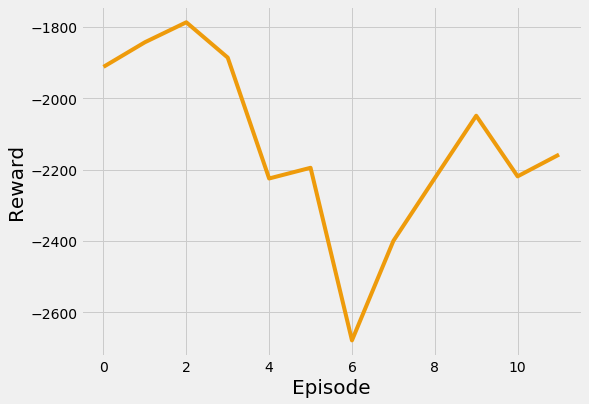

Max -1787


In [17]:

if __name__ == '__main__':
    tf.enable_eager_execution()

    dqn_agent = Agent("Seaquest-v0",
                      gamma=0.9,
                      buffer_size=10000,
                      batch_size=32,
                      buffer_start=10000,
                      target_update_freq=10000,
                      update_freq=4,
                      learning_rate=0.00025,
                      max_episodes=500000,
                      max_steps=200000000,
                      exp_init=1.0,
                      exp_final=0.05,
                      exp_final_frame=500000)
    dqn_agent.train()

    plot1 = dqn_agent.plot1
    plot2 = dqn_agent.plot2

    style.use('fivethirtyeight')

    plt.figure(figsize=(8, 6))

    plt.xlabel('Episode', fontsize=20)
    plt.ylabel('Reward', fontsize=20)

    plt.plot(plot2, color='#ee9b0b')

    plt.show()
    print("Max", max(plot2))